In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install tensorflow

import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Mounted at /content/drive


In [ ]:
seed_constant = 123
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
%cd /content/drive/MyDrive
#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar

#!unrar x UCF101.rar

/content/drive/MyDrive


Visualization


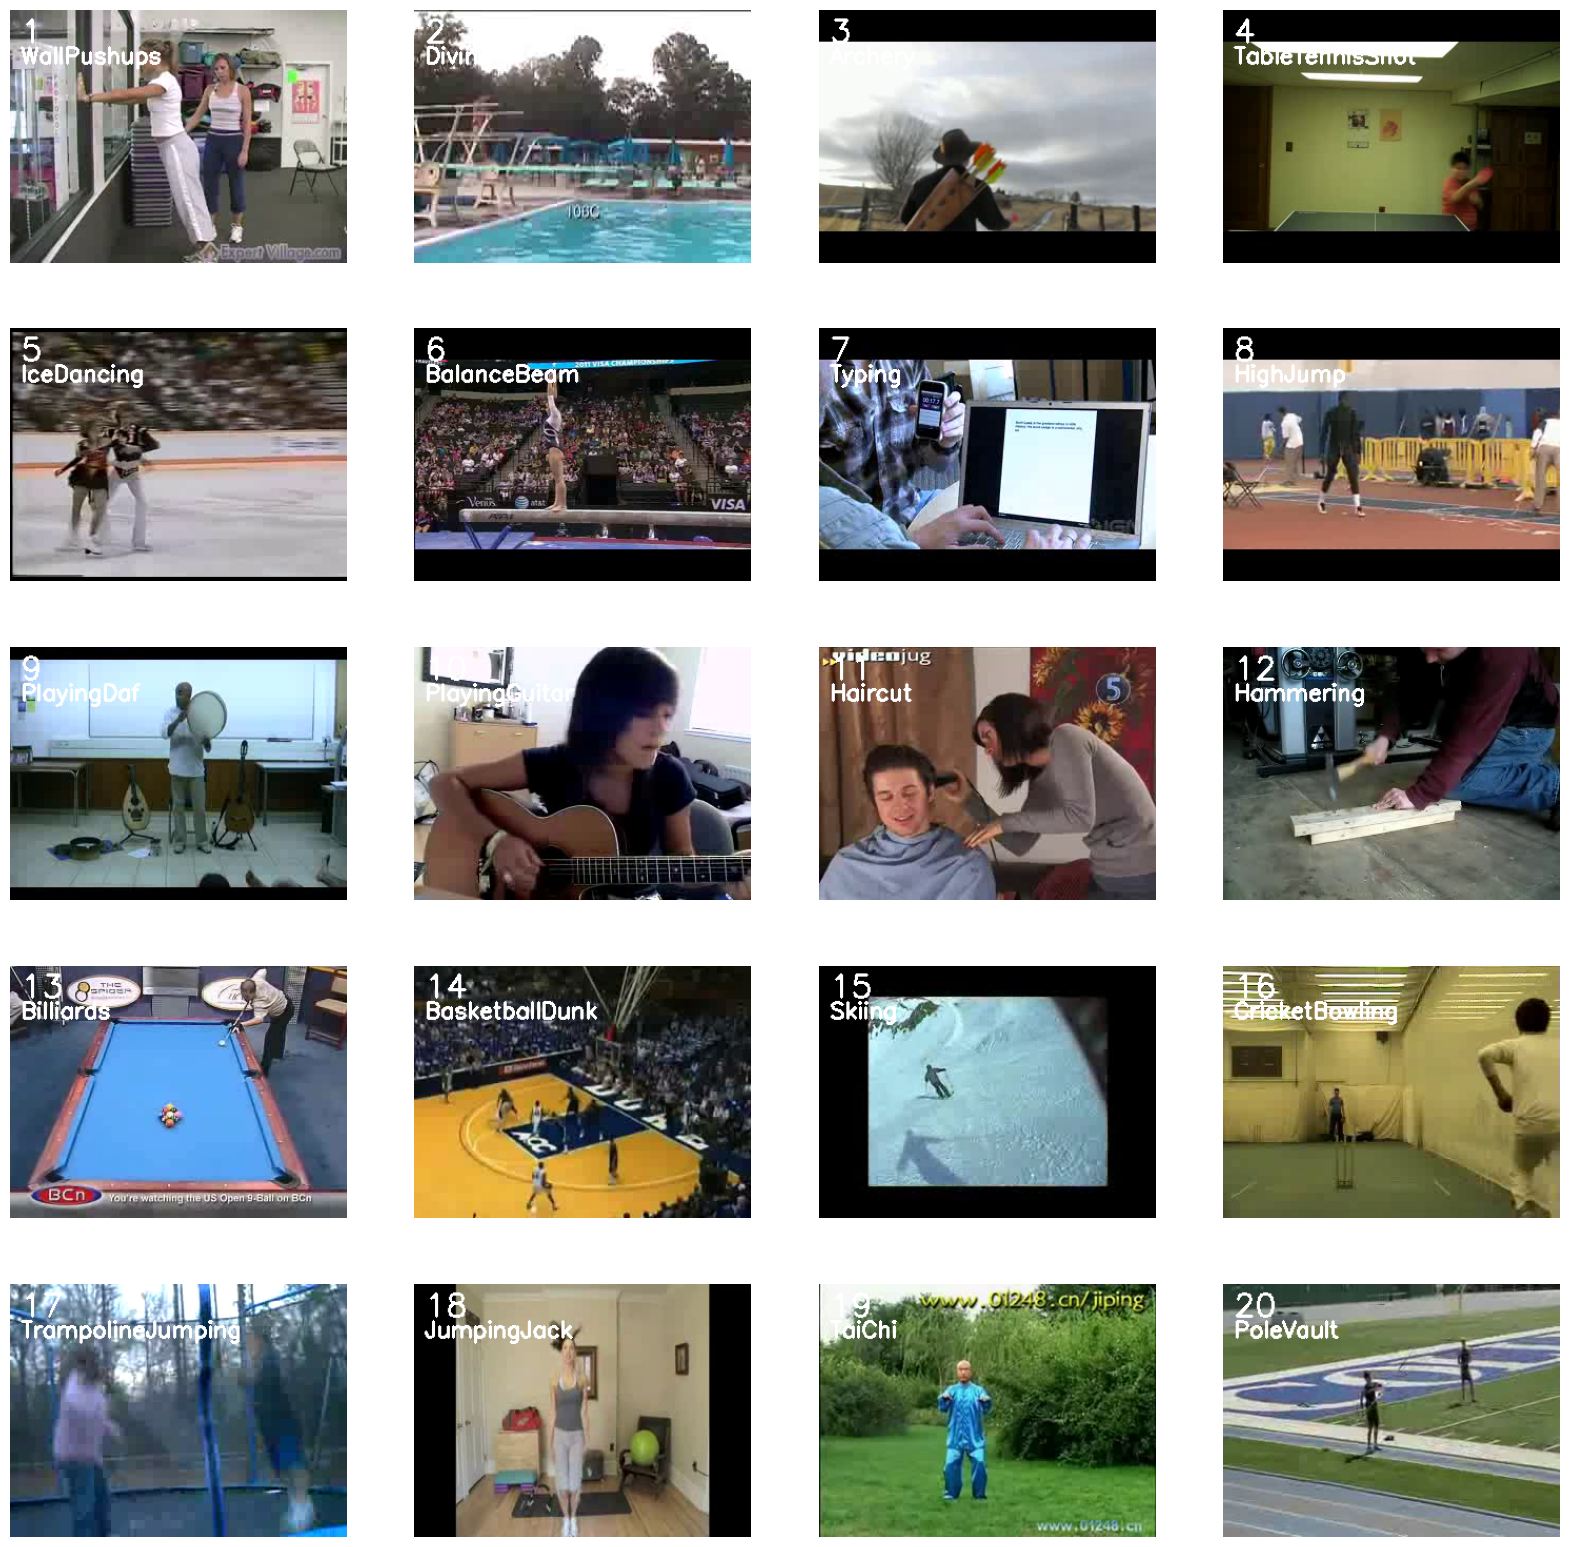

In [ ]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('/content/drive/MyDrive/UCF-101')
random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'/content/drive/MyDrive/UCF-101/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/UCF-101/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()

    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Display the class label (selected_class_Name) on the frame
    cv2.putText(rgb_frame, selected_class_Name, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2) # Updated line

    cv2.putText(rgb_frame, f'{counter}', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2) # existing line for counter

    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [ ]:
image_height, image_width = 64, 64
sequence_length = 20

DATASET_DIR= "/content/drive/MyDrive/UCF-101"

Classes_list = ['ApplyEyeMakeup','ApplyLipstick','Archery']

In [ ]:
def frames_extraction(video_path):
    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/sequence_length), 1)

    for frame_counter in range(sequence_length):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (image_height, image_width))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list


In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(Classes_list):
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == sequence_length:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Return statement moved outside the loop
    features = np.asarray(features)
    labels = np.asarray(labels)
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

one_hot_encoded_labels = to_categorical(labels)

Extracting Data of Class: ApplyEyeMakeup
Extracting Data of Class: ApplyLipstick
Extracting Data of Class: Archery


In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

**Creating Model**


In [ ]:
def create_covLstm_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh',
                         recurrent_dropout=0.2, return_sequences=True,
                         input_shape=(sequence_length, image_height, image_width, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh',
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh',
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh',
                         recurrent_dropout=0.2, return_sequences=False))  # return_sequences=False here

    # Remove the 3D pooling since the tensor is now 4D
    model.add(Flatten())  # Flatten the 4D output
    model.add(Dense(len(Classes_list), activation='softmax'))

    model.summary()
    return model


In [ ]:
ConLstm_model = create_covLstm_model()

print("model Created")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 5, 5, 16)            │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           1,203 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,203 (133.61 KB)

 Trainable params: 34,203 (133.61 KB)

 Non-trainable params: 0 (0.00 B)

model Created


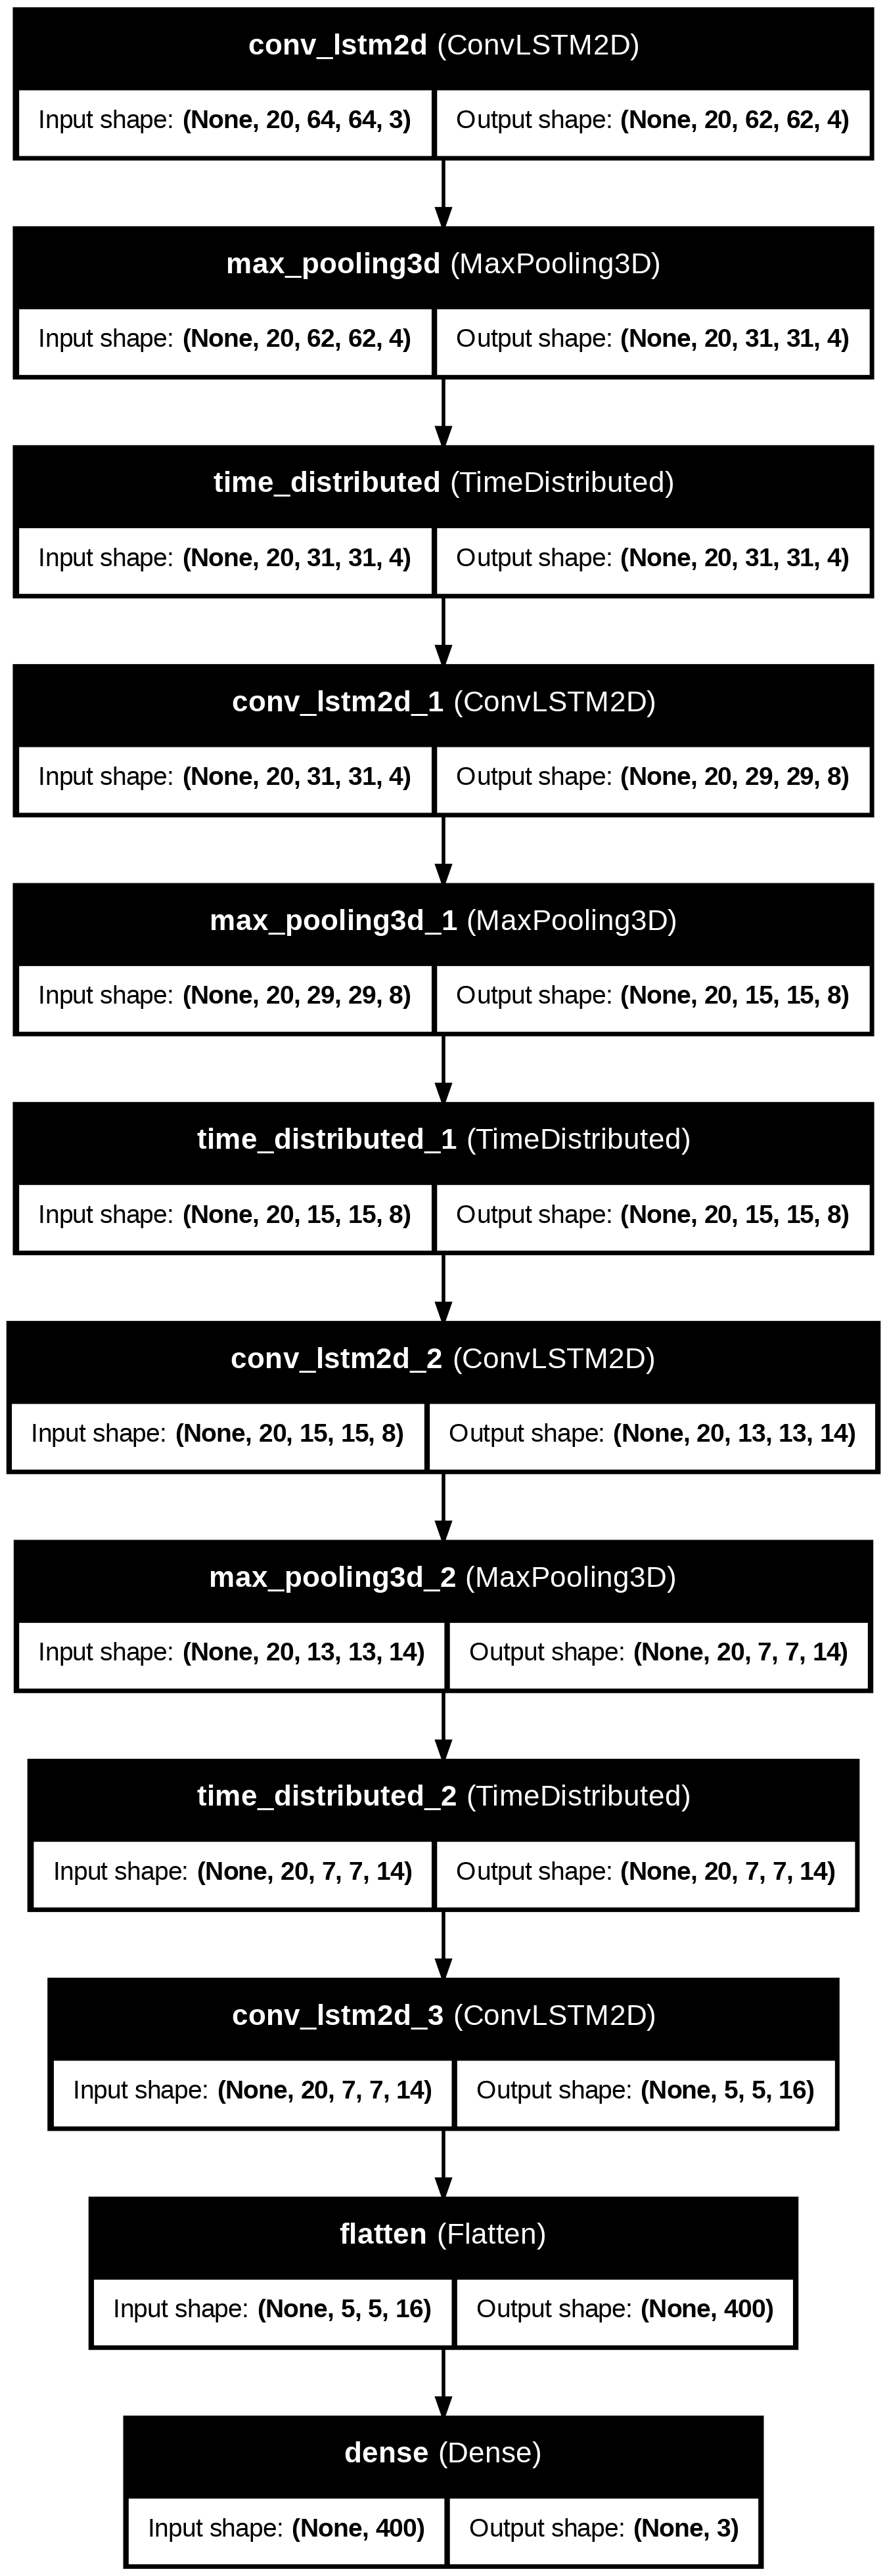

In [ ]:
from keras.utils import plot_model

plot_model(ConLstm_model, to_file="ConLstm_model_structure_plot.png", show_shapes=True, show_layer_names=True)


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

ConLstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

ConLstm_model_training_history = ConLstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                   shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 126s 900ms/step - accuracy: 0.3678 - loss: 1.1056 - val_accuracy: 0.4154 - val_loss: 1.0821
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.4589 - loss: 1.0195 - val_accuracy: 0.6000 - val_loss: 0.9618
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5646 - loss: 0.8591 - val_accuracy: 0.6615 - val_loss: 0.7844
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7248 - loss: 0.6453 - val_accuracy: 0.6154 - val_loss: 0.9504
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6732 - loss: 0.6862 - val_accuracy: 0.7538 - val_loss: 0.6267
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8268 - loss: 0.4583 - val_accuracy: 0.8154 - val_loss: 0.4876
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8519 - loss: 0.3875 - val_accuracy: 0.8154 - val_loss: 0.4645
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8947 - loss: 0.2679 - val_accuracy: 0.8308

In [ ]:
model_evaluation_history = ConLstm_model.evaluate(features_test, labels_test)

In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'ConLstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

ConLstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_traning_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_traning_history.history[metric_name_1]
  metric_value_2 = model_traning_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))
  plt.legend()

In [ ]:
plot_metric(ConLstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
plot_metric(ConLstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total validation Accuracy')

In [ ]:
!pip install yt-dlp

import subprocess

def download_video(video_url, save_path):
    try:
        # Use yt-dlp directly as a subprocess
        subprocess.run([
            "yt-dlp",
            video_url,
            "-o", f"{save_path}/%(title)s.%(ext)s",
            "--format", "mp4"
        ], check=True)
        print("Download completed successfully!")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred: {e}")

video_url = "https://youtu.be/f4Vff10JnrI?si=AN5E2sWjCjzTu2OD"
save_path = "./"  # Save to current directory
download_video(video_url, save_path)




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 64.6 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np

# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64  # Match model input size
SEQUENCE_LENGTH = 20

def extract_frames_from_video(video_path):
    """Extract frames from a video."""
    video_reader = cv2.VideoCapture(video_path)
    frames_list = []

    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(total_frames // SEQUENCE_LENGTH, 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0  # Normalize
        frames_list.append(normalized_frame)

    video_reader.release()
    return np.array(frames_list)


In [ ]:
def predict_video_class(video_path, model, class_labels):
    """Predict the class of a video."""
    frames = extract_frames_from_video(video_path)
    if len(frames) != SEQUENCE_LENGTH:
        print("Insufficient frames for prediction.")
        return None
    # Expand dimensions to match model input
    frames = np.expand_dims(frames, axis=0)
    prediction = model.predict(frames)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label

# Example usage
CLASS_LABELS = ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery']  # Your classes
video_path = "/content/Beginners Eye Makeup Tutorial ｜ Parts of the Eye ｜ How To Apply Eyeshadow.mp4"  # Replace with your video path
predicted_label = predict_video_class(video_path, ConLstm_model, CLASS_LABELS)

if predicted_label:
    print(f"The predicted class is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The predicted class is: ApplyLipstick
